# MGUA and Neural Network Implementation

## 1. Load and Preprocess Data

In [6]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Split features and target variable
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Normalize target variable for neural network
y_train = y_train / y_train.max()
y_test = y_test / y_test.max()


## 2. MGUA Implementation

In [7]:

# Function to evaluate a single feature combination
def evaluate_combination(combination, X_train, y_train, X_test, y_test):
    X_train_subset = X_train[:, combination]
    X_test_subset = X_test[:, combination]
    model = LinearRegression()
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    return mse, model, combination

# MGUA with parallel processing for optimization
def mgua_parallel(X_train, y_train, X_test, y_test, max_features=None, n_jobs=-1):
    n_features = X_train.shape[1]
    max_features = max_features or n_features
    best_models = []
    mse_list = []

    for k in range(1, max_features + 1):
        combinations_list = list(combinations(range(n_features), k))
        results = [
            evaluate_combination(comb, X_train, y_train, X_test, y_test)
            for comb in combinations_list
        ]
        best_mse, best_model, best_combination = min(results, key=lambda x: x[0])
        best_models.append((best_model, best_combination))
        mse_list.append(best_mse)
        if k > 1 and best_mse > np.min(mse_list[:-1]):
            break

    min_mse_index = np.argmin(mse_list)
    final_model, final_combination = best_models[min_mse_index]
    return final_model, final_combination, mse_list[min_mse_index]

# Run MGUA on the sampled data
final_model_sample, final_combination_sample, final_mse_sample = mgua_parallel(
    X_train, y_train, X_test, y_test, max_features=3
)

print("Coefficients:", final_model_sample.coef_)
print("Best feature combination:", final_combination_sample)
print("MSE:", final_mse_sample)


Coefficients: [-1.834837    1.82921663  1.14523351]
Best feature combination: (3, 4, 5)
MSE: 0.03833763873611363


## 3. Neural Network Implementation

Epoch 1/50


C:\Users\Misha\PycharmProjects\MTOI\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4380/4380 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0391 - val_loss: 0.0351
Epoch 2/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0348 - val_loss: 0.0349
Epoch 3/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0346 - val_loss: 0.0345
Epoch 4/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0345 - val_loss: 0.0347
Epoch 5/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0343 - val_loss: 0.0346
Epoch 6/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0342 - val_loss: 0.0342
Epoch 7/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0341 - val_loss: 0.0348
Epoch 8/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0342 - val_loss: 0.0344
Epoch 9/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0341 - val_loss: 0.0341
Epoch 10/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0340 - val_loss: 0.0343
Epoch 11/50
4380/4380 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0340 - val_loss: 0.0343
Epoch 12/50
4380/4380 ━━━━━━━━━━━━━━━━━━━

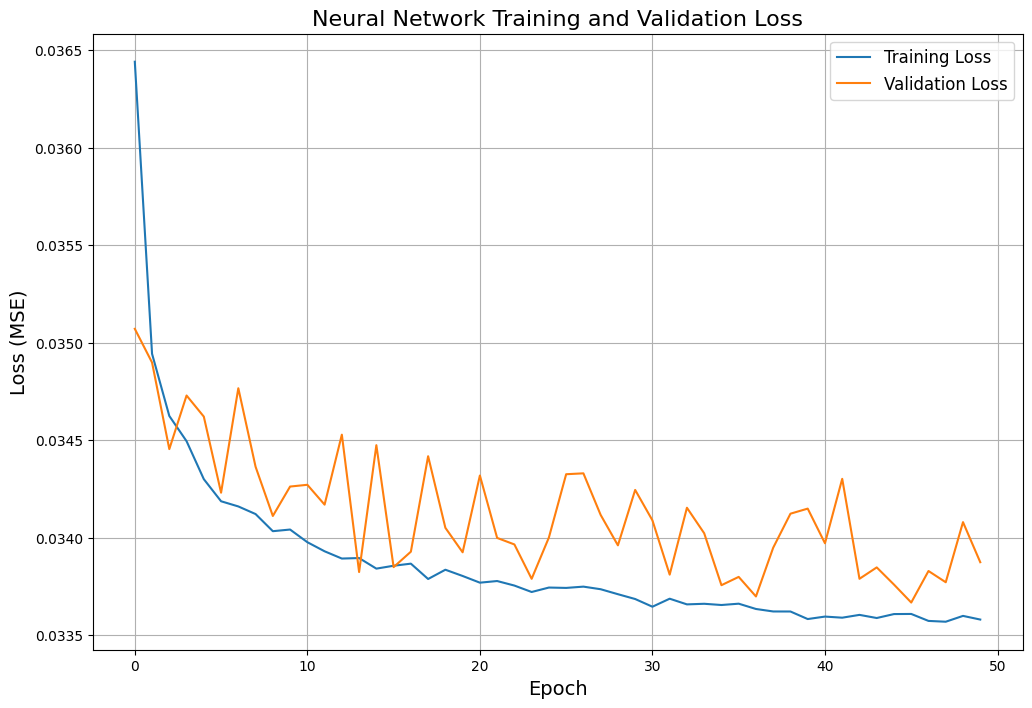

In [8]:

# Neural Network Implementation
def train_neural_network(X_train, y_train, X_test, y_test):
    # Define the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

    return model, history

# Train the neural network on the best feature combination
X_train_best = X_train[:, final_combination_sample]
X_test_best = X_test[:, final_combination_sample]

nn_model, nn_history = train_neural_network(X_train_best, y_train, X_test_best, y_test)

# Plot Neural Network Loss
plt.figure(figsize=(12, 8))
plt.plot(nn_history.history['loss'], label='Training Loss', color='tab:blue')
plt.plot(nn_history.history['val_loss'], label='Validation Loss', color='tab:orange')
plt.title('Neural Network Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## 4. Actual vs Predicted for Neural Network

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


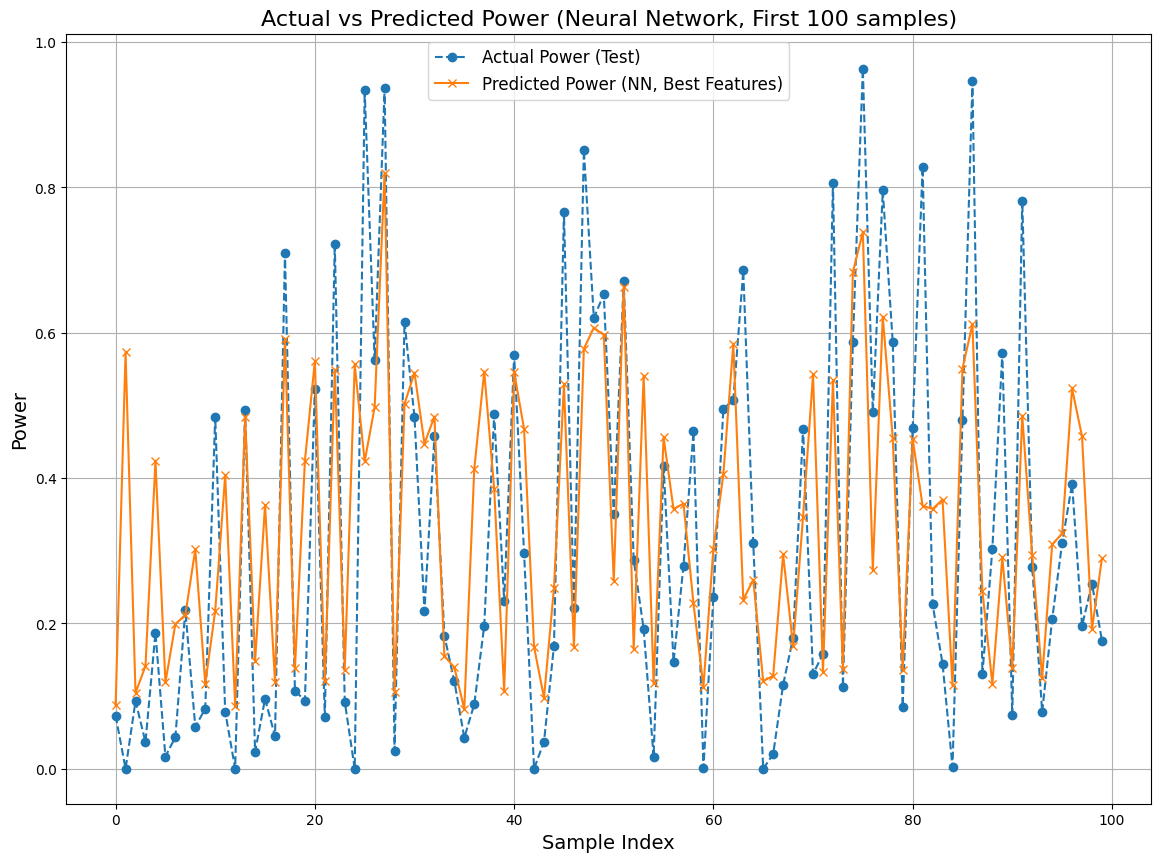

In [9]:

# Final Actual vs Predicted for the neural network
nn_predictions = nn_model.predict(X_test_best[:100])

plt.figure(figsize=(14, 10))
plt.plot(y_test[:100], label="Actual Power (Test)", linestyle="--", marker="o", color="tab:blue")
plt.plot(nn_predictions, label="Predicted Power (NN, Best Features)", linestyle="-", marker="x", color="tab:orange")
plt.title("Actual vs Predicted Power (Neural Network, First 100 samples)", fontsize=16)
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Power", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
